In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize

import random
import sys, os
import multiprocessing

In [5]:
# use gpu for training if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model specification
Dimension calculation in the 2D convolution layer<br>
n_out = (n_in + 2p - k)/s + 1 <br>

where,<br>
n_in: number of input features<br>
n_out: number of output features<br>
k: convolution kernel size<br>
p: convolution padding size<br>
s: convolution stride size<br>

In [6]:
class Conv_net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Conv_net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=11)
        self.conv2 = nn.Conv2d(6, 12, 12)
        self.conv3 = nn.Conv2d(12, 24, 11)
        self.conv4 = nn.Conv2d(24, 48, 12)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(48 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) #（3,224,224）->(6,214,214)
        x = self.pool(x) #(6,214,214)->(6,107,107)
        x = F.relu(self.conv2(x)) #（6,107,107）->(12,96,96)
        x = self.pool(x) #(12,96,96)->(12,48,48)
        x = F.relu(self.conv3(x)) #（12,48,48）->(24,38,38)
        x = self.pool(x) #(24,38,38)->(24,19,19)
        x = F.relu(self.conv4(x)) #（24,19,19）->(48,8,8)
        x = self.pool(x) #(48,8,8)->(48,4,4)
        x = x.view(-1, 48 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Dimensionality checking with random inputs
Recommend to do so to ensure the data flow in your model is as you expected

In [7]:
x = torch.randn(64, 3, 224, 224)
model = Conv_net(in_channels=3, num_classes=2)
out = model(x)
print(out.shape)

torch.Size([64, 2])


### Global Variables Specification
Configure this part to your preferred setting before you start training

In [8]:
num_classes = 2
learning_rate = 0.001
batch_size = 128
num_epochs = 50
num_workers = 16 # multiprocessing.cpu_count() 
in_channels = 3 # fashion-mnist only has 1 channel
early_stopping_criteria= 3

train_proportion = 0.8
val_proportion = 0.1
test_proportion = 0.1

data_dir = "/mnt/addtional_data_ssd/pytorch_tutorials/data" # change this path to your preferred directory to store fashion minst data
model_dir = "/mnt/addtional_data_ssd/pytorch_tutorials/model" 
image_root_dir = os.path.join(data_dir, "dogs-vs-cats", "images")

csv_fn = os.path.join(data_dir, "dogs-vs-cats", "cats_dogs_labels.csv")
saved_model_fn = os.path.join(model_dir, "best_cnn_catsdogs_model.pt")

### Custom Dataset 
Data adapted from this famous [dogs vs. cats](num_classes) kaggle competition

In [9]:
class CatsAndDogDataset(Dataset):
    def __init__(self, csv_fn, image_root_dir, transform=None):
        self.annotations = pd.read_csv(csv_fn)
        self.image_root_dir = image_root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        image = resize(image, (224, 224)) 
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [10]:
dataset = CatsAndDogDataset(csv_fn=csv_fn, image_root_dir=image_root_dir)
image, label = dataset[0]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
tensor(1)


In [8]:
train_size = int(len(dataset) * train_proportion)
val_size = int(len(dataset) * val_proportion)
test_size = len(dataset) - train_size - val_size

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

number samples in train: 20000
number samples in val: 2500
number samples in test: 2500


In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [10]:
# check the dimensions of the data
image, target = train_dataset[2]
print("input image has shape:")
print(image.shape)

input image has shape:
torch.Size([3, 224, 224])


### Model Initialization, Loss, Optimizer

In [11]:
# instantiate the model
clf = Conv_net(in_channels=in_channels, num_classes=num_classes)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

Conv_net(
  (conv1): Conv2d(3, 6, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(12, 12), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(11, 11), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(12, 12), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


### Initialize a dictionary to record training progress

In [12]:
train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

### Train the model
[Model saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [13]:
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()

        # print training stat every 20 steps
        if ((batch_idx+1) % 20==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/20:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")
            

[epoch 0 step 19] running training loss: 0.693
[epoch 0 step 39] running training loss: 0.692
[epoch 0 step 59] running training loss: 0.691
[epoch 0 step 79] running training loss: 0.689
[epoch 0 step 99] running training loss: 0.692
[epoch 0 step 119] running training loss: 0.693
[epoch 0 step 139] running training loss: 0.693
[epoch 0] val loss: 0.692, accuracy: 50.440%
current best validation loss: 0.692
=====>save the best model
--------------------------------------------
[epoch 1 step 19] running training loss: 0.693
[epoch 1 step 39] running training loss: 0.692
[epoch 1 step 59] running training loss: 0.689
[epoch 1 step 79] running training loss: 0.686
[epoch 1 step 99] running training loss: 0.688
[epoch 1 step 119] running training loss: 0.685
[epoch 1 step 139] running training loss: 0.693
[epoch 1] val loss: 0.693, accuracy: 50.200%
validation loss stops decreasing for 1 epoch
--------------------------------------------
[epoch 2 step 19] running training loss: 0.695
[epo

### Test the network on the test data

In [14]:
# load the saved best model
clf = Conv_net(in_channels=in_channels, num_classes=num_classes)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device) # move the model to gpu if available

clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")


testing loss: 0.515, testing accuracy: 75.960%


### Plot learning curve

In [15]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

    train_loss  train_acc  val_loss  val_acc
0     0.691863    0.51030  0.692407   0.5044
1     0.689968    0.51935  0.693200   0.5020
2     0.693211    0.50710  0.693087   0.5004
3     0.692182    0.51080  0.691116   0.5124
4     0.686879    0.53635  0.685997   0.5416
5     0.682466    0.55110  0.679932   0.5584
6     0.680564    0.56050  0.683824   0.5440
7     0.676427    0.57275  0.680026   0.5616
8     0.660746    0.60675  0.649466   0.6204
9     0.626494    0.65165  0.590380   0.7024
10    0.584871    0.69065  0.549318   0.7264
11    0.534867    0.73050  0.551837   0.7240
12    0.488457    0.76395  0.509988   0.7580
13    0.440886    0.79060  0.524265   0.7488
14    0.383947    0.82150  0.564528   0.7520
15    0.323435    0.85645  0.581472   0.7480


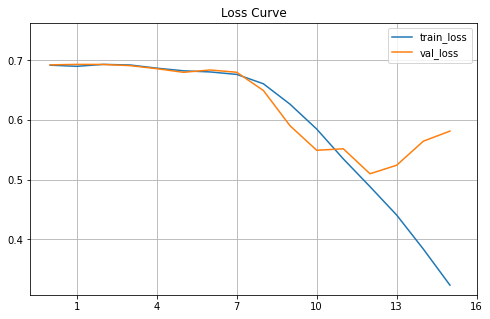

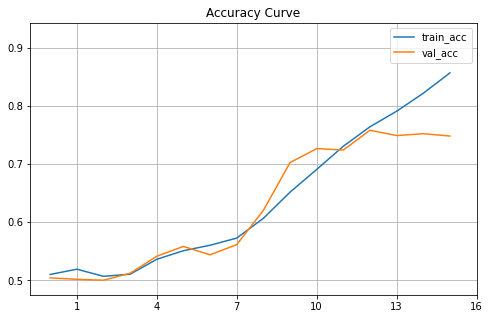

In [16]:
train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")